In [1]:
import numpy as np
import pints
import pints.plot
import pints_smol_moments_1_normalised_jit as toy
import matplotlib.pyplot as plt
from scipy.stats import moment
import pandas as pd



Select the desired model, true parameters and time array.

Then simulate to get synthetic data

In [2]:

model = toy.SmolModel(None,None)


true_parameters = [0.0003, 900]


times = np.linspace(20, 97, 78)

df = pd.read_csv('s11_inference_input_multi_well_t_20.csv', header=None)
org_values = np.transpose(df.to_numpy())



out_array = np.zeros((78,1))
out_array[:,0] = np.mean(org_values,axis=1)


# print(st_dev)

# print(np.mean(org_values, axis=1))
# print(centred_moment_3)



Add noise to the data (using random sampling from normal distribution)

In [3]:

# noise = 9
# values = org_values + np.random.normal(0, noise, org_values.shape)

size_noise = 1
noise_value = 1
# # Create a list with the specified size filled with a placeholder value
noise_arr = [noise_value for _ in range(size_noise)]
# noise_arr[0] = 1
# noise_arr[1] = 1
# noise_arr[2] = 1
# noise_arr[3] = 1


Set-up pints problem and log likelihoods

In [4]:

# problem = pints.MultiOutputProblem(model, times, centred_moments)
problem = pints.MultiOutputProblem(model, times, out_array)

log_likelihood = pints.GaussianLogLikelihood(problem)
# log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)

print('Original problem dimension: ' + str(problem.n_parameters()))
print('New dimension: ' + str(log_likelihood.n_parameters()))
# print('New dimension: ' + str(log_likelihood_2.n_parameters()))

true_parameters += noise_arr
# print(true_parameters)



Original problem dimension: 2
New dimension: 3


Create uniform log prior

In [5]:

# Define the size of the list
size = 3
placeholder_lower_value = 0
placeholder_upper_value = 1000
 
# Create a list with the specified size filled with a placeholder value
prior_arr_lower = [placeholder_lower_value for _ in range(size)]
prior_arr_upper = [placeholder_upper_value for _ in range(size)]
prior_arr_lower[0] = 0.00001
prior_arr_upper[0] = 0.001
prior_arr_lower[1] = 1
prior_arr_upper[1] = 4000
prior_arr_lower[2] = 0
prior_arr_upper[2] = 100



# log_prior = pints.UniformLogPrior(
#     [0.000001, 1, 1],
#     [0.01, 10000, 100]
#     )
log_prior = pints.UniformLogPrior(
    prior_arr_lower,
    prior_arr_upper
    )

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)


/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_57139/938214955.py:22: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


In [6]:

xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 10000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.SliceDoublingMCMC)
mcmc.set_max_iterations(ITERS)
chains = mcmc.run()
print(chains)



Using Slice Sampling - Doubling
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.4
1     222     0:00.7
2     369     0:01.0
3     480     0:01.2
20    2472    0:05.5
40    4470    0:09.6
60    6579    0:13.9
80    8739    0:18.6
100   10806   0:23.0
120   12870   0:28.0
140   14943   0:32.4
160   17007   0:37.3
180   18900   0:41.3
200   20904   0:45.6
220   22944   0:49.9
240   24918   0:54.0
260   26922   0:58.3
280   28995   1:02.6
300   31044   1:06.9
320   33105   1:11.3
340   35001   1:15.3
360   37275   1:20.2
380   39240   1:24.3
400   41130   1:28.3
420   43239   1:33.0
440   45333   1:37.6
460   47481   1:42.2
480   49491   1:46.6
500   51441   1:50.7
520   53421   1:54.7
540   55548   1:59.1
560   57654   2:03.9
580   59676   2:08.2
600   61671   2:12.7
620   63576   2:16.9
640   65868   2:21.9
660   67815   2:26.1
680   69942   2:30.8
700   72114   2:35.4
720   74361   2:40.2
740   76257   2:44.2
760   78225   2:48.4
780   80292   2:

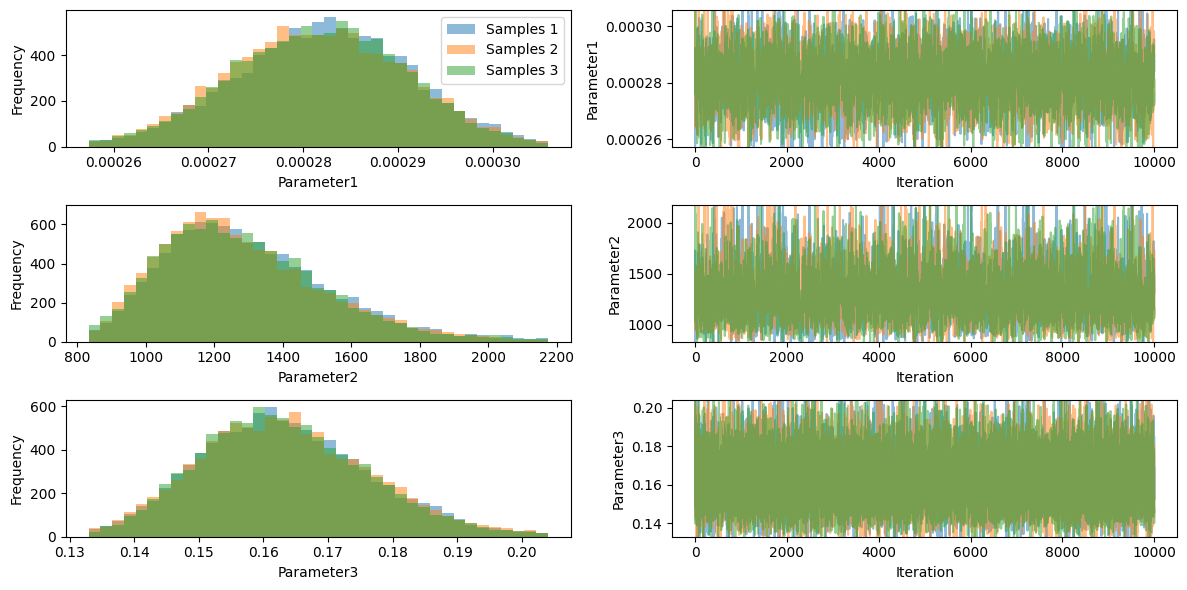

In [7]:

pints.plot.trace(chains, n_percentiles=99)
plt.savefig("mcmc.png")
plt.show()


In [8]:

# ITERS = 100
AllChains = chains[0,100:1000,:]
# np.asarray(AllChains)
print(np.shape(AllChains))
print(AllChains[0])
print(AllChains)


(900, 3)
[2.91228657e-04 1.46945194e+03 1.71495041e-01]
[[2.91228657e-04 1.46945194e+03 1.71495041e-01]
 [2.89366553e-04 1.53501918e+03 1.53362190e-01]
 [2.90290589e-04 1.43396240e+03 1.71178468e-01]
 ...
 [2.83130249e-04 1.35674166e+03 1.69774796e-01]
 [2.82160212e-04 1.10566461e+03 1.75399357e-01]
 [2.78759616e-04 1.21421465e+03 1.51644886e-01]]


In [9]:

for I in range(3-1):
    AllChains_add = chains[I+1,100:1000,:]
    AllChains = np.concatenate((AllChains,AllChains_add), axis=0)


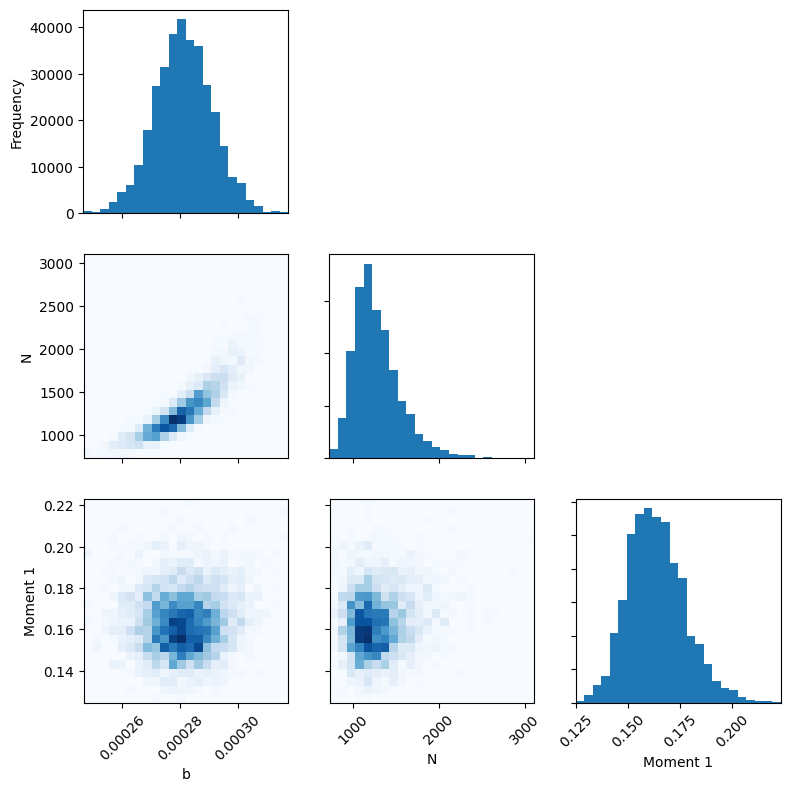

In [10]:


parameter_names = ["b","N", "Moment 1"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","N", "Moment 1"])
plt.show()

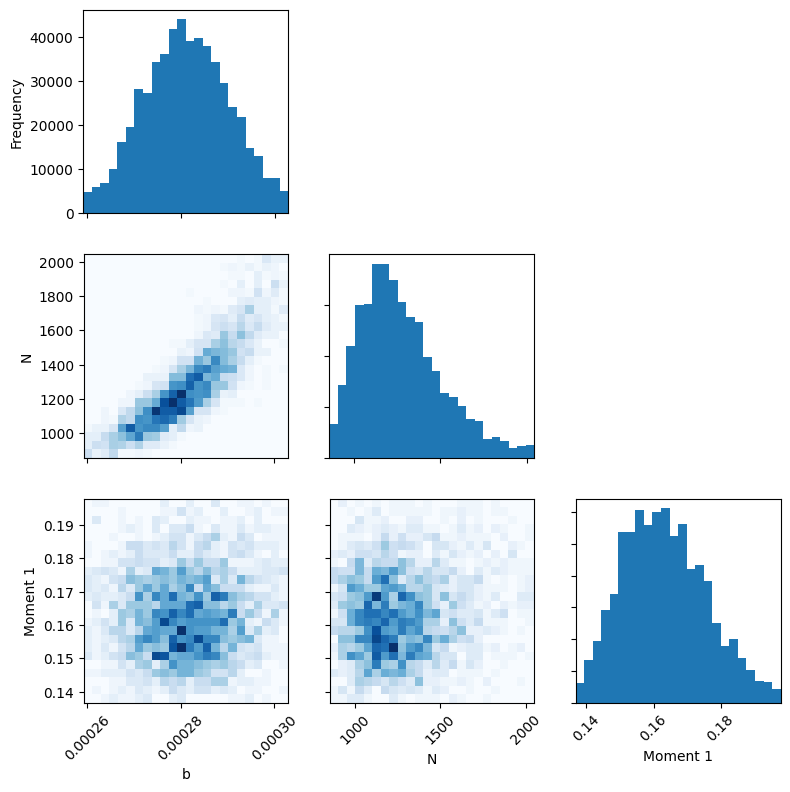

In [11]:
parameter_names = ["b","N", "Moment 1"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","N", "Moment 1"],
                    n_percentiles=97)
                    
plt.show()

In [12]:
# parameter_names = ["b","N", "Moment 2"]
# #pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)
# print(AllChains[0])
# pints.plot.pairwise(AllChains[:,[0,1,3]], heatmap=True, 
#                     parameter_names=["b","N", "Centres Moment 2"])
# plt.savefig("Pints_pairwise.png", dpi =300)
# plt.show()


In [13]:
parameter_names = ["b","N", "Moment 1"]
results = pints.MCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)


<class 'pints._mcmc._summary.MCMCSummary'>
param     mean     std.    2.5%    25%      50%      75%      97.5%    rhat    ess      ess per sec.
--------  -------  ------  ------  -------  -------  -------  -------  ------  -------  --------------
b         0.00     0.00    0.00    0.00     0.00     0.00     0.00     1.00    1497.55  0.70
N         1293.31  252.79  906.82  1111.79  1256.20  1439.22  1878.47  1.00    1497.84  0.70
Moment 1  0.16     0.01    0.14    0.15     0.16     0.17     0.19     1.00    4458.59  2.08


In [14]:
from tabulate import tabulate
class MyMCMCSummary(pints.MCMCSummary):
    def __str__(self):
        """
        Prints posterior summaries for all parameters to the console, including
        the parameter name, posterior mean, posterior std deviation, the
        2.5%, 25%, 50%, 75% and 97.5% posterior quantiles, rhat, effective
        sample size (ess) and ess per second of run time.
        """
        if self._summary_str is None:
            headers = [
                'param', 'mean', 'std.',
                '2.5%', '25%', '50%', '75%', '97.5%',
                'rhat', 'ess']
            if self._time is not None:
                headers.append('ess per sec.')

            self._summary_str = tabulate(
                self._summary_list,
                headers=headers,
                numalign='left',
                floatfmt='.3g',
            )

        return self._summary_str
    


In [15]:

parameter_names = ["b","N", "Moment 1"]
results = MyMCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)

<class '__main__.MyMCMCSummary'>
param     mean      std.      2.5%      25%       50%       75%       97.5%     rhat    ess       ess per sec.
--------  --------  --------  --------  --------  --------  --------  --------  ------  --------  --------------
b         0.000282  9.44e-06  0.000263  0.000275  0.000282  0.000288  0.0003    1       1.5e+03   0.698
N         1.29e+03  253       907       1.11e+03  1.26e+03  1.44e+03  1.88e+03  1       1.5e+03   0.698
Moment 1  0.163     0.0136    0.14      0.154     0.162     0.172     0.193     1       4.46e+03  2.08


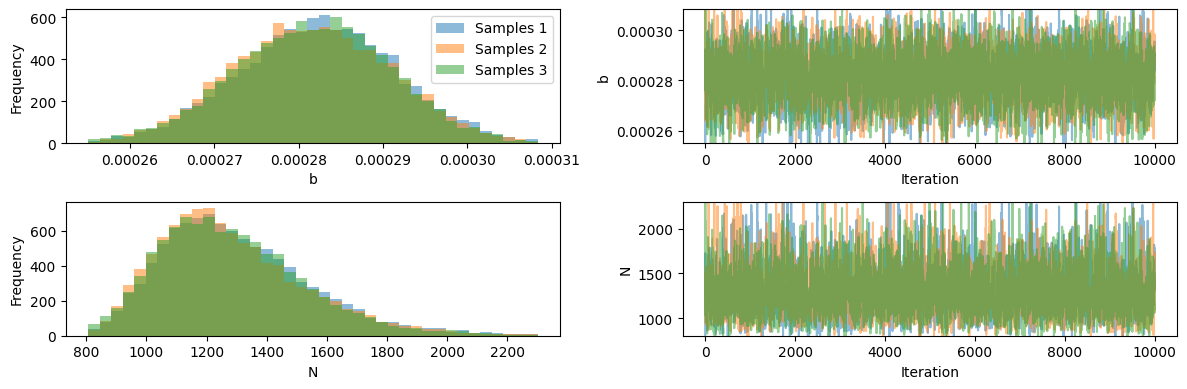

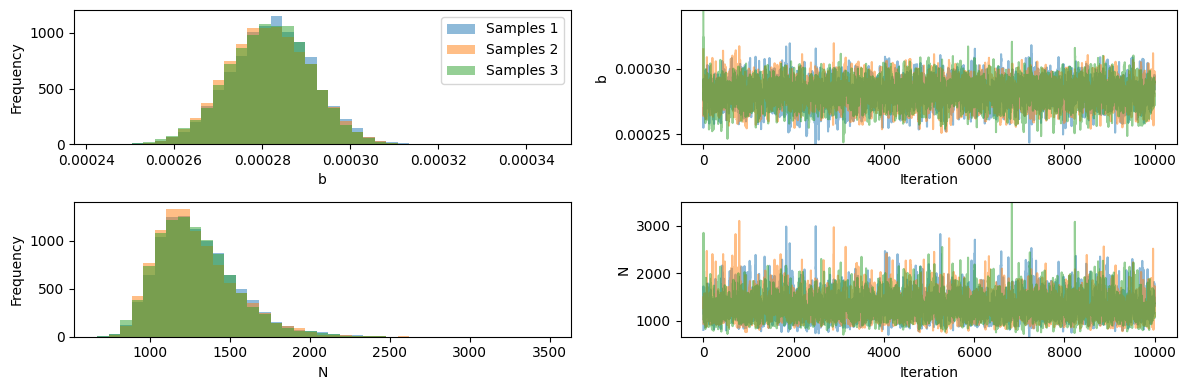

In [16]:
pints.plot.trace(chains[:,:,[0,1]], n_percentiles=99.5, parameter_names=["b","N"])
plt.savefig("pints_out_extremes_removed.png", dpi=300)
plt.show()
pints.plot.trace(chains[:,:,[0,1]], parameter_names=["b","N"])
plt.savefig("pints_out.png", dpi=300)
plt.show()